By Akinde Kadjo

**Goal:** The Goal is to build a model that will be able to distinguish happy sounds from sad sounds and angry sounds. The data used here was collected from [Kaggle](https://www.kaggle.com/datasets/uldisvalainis/audio-emotions/data)

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import os
from glob import glob
from tqdm import tqdm
from tqdm.keras import TqdmCallback
import time

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, regularizers
from keras.optimizers import RMSprop, Adam

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

# Functions

In order to keep a clean notebook, I'm storing all of the functions that I've created in this section. These functions pertain to data extraction, data cleaning, plots, prediction models and regression outputs.

In [2]:
#get .wav files within a folder
def get_wav(path):
    # Get a list of all files and directories in the specified path
    files = os.listdir(path)
    # Filter the list to only include .wav files
    wav_files = [os.path.join(path, f) for f in files if f.endswith('.wav')]
    return wav_files

In [3]:
#extract all the files within the path/directory 
#then convert them into mel spectrogram array
def audiotoarray(path):
    new_sr, set_time = 22050, 2
    new_len = set_time*new_sr
    wave_files = get_wav(path)
    audio = []
    for i in range(len(wave_files)):
        y, sr = librosa.load(wave_files[i])
        y = librosa.resample(y,orig_sr=sr, target_sr=new_sr)
        y_trimmed, _ = librosa.effects.trim(y, top_db=10) #remove silence
        #padded or cut to new length
        num_zeros = new_len - len(y_trimmed) #zeros to pad
        new_y = (np.pad(y_trimmed, (0, num_zeros), 'constant')) if len(y_trimmed)<new_len else y_trimmed[0: new_len]
        #mel spectrogram
        S = librosa.feature.melspectrogram(y=new_y, sr=new_sr, n_mels=128 * 2,)
        H_db_mel = librosa.amplitude_to_db(S, ref=np.max)
        db = (H_db_mel+80)/80 # normalization to 1
        audio.append(db)
    audio_array = np.array(audio, dtype=np.float32)
        
    return audio_array

# Audio Samples

In [4]:
happy_files = get_wav('Happy')
# Play the first file
ipd.Audio(happy_files[0])

In [5]:
angry_files = get_wav('Angry')
# Play the first file
ipd.Audio(angry_files[0])

In [6]:
sad_files = get_wav('Sad')
# Play the first file
ipd.Audio(sad_files[0])

In [7]:
#the first component is the signal, the second is the sample rate
y = (librosa.load(happy_files[0]))[0]
y[0:10]

array([-7.9101634e-13, -9.8974296e-14,  6.0890041e-13,  1.1160881e-12,
       -7.4001168e-13,  1.6522482e-12, -2.8410980e-12,  4.8570857e-12,
       -7.2625040e-12,  1.0789991e-11], dtype=float32)

# Visualization

## Raw signal

Let's plot the 3 sounds above as signals

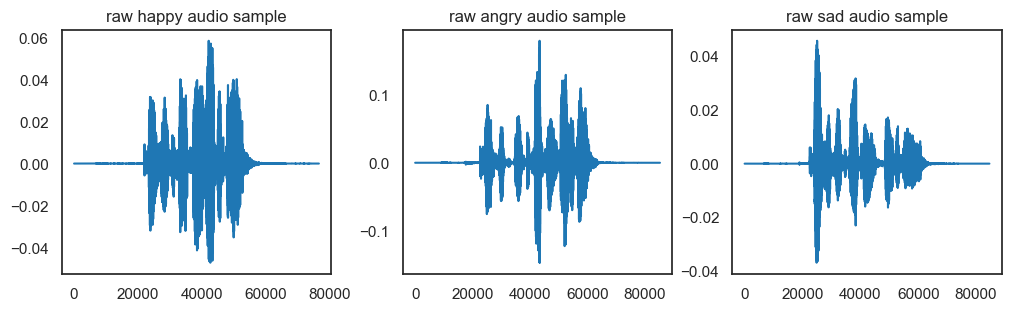

In [8]:
fig, ax = plt.subplots(1,3,figsize = (10,3),constrained_layout=True)
ax[0].plot((librosa.load(happy_files[0]))[0])
ax[0].set_title('raw happy audio sample') 
ax[1].plot((librosa.load(angry_files[0]))[0])
ax[1].set_title('raw angry audio sample') 
ax[2].plot((librosa.load(sad_files[0]))[0])
ax[2].set_title('raw sad audio sample') 
plt.show()

Let's keep in mind that for these 3 samples above, the actor is repeating the same sentence with different emotions. "Sad" has the lowest amplitude (gradually decreasing in a triangular fashion ) while "angry" has the highest amplitude. "Happy" is even tempered.

## Spectrogram

For reference, A spectrogram is a visual representation of the frequency content of a signal over time. It is a 2D plot that shows the frequency spectrum of a signal on the y-axis and time on the x-axis. [More here](https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53)

In [9]:
D = librosa.stft((librosa.load(happy_files[0]))[0])
H_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
D = librosa.stft((librosa.load(angry_files[0]))[0])
A_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
D = librosa.stft((librosa.load(sad_files[0]))[0])
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

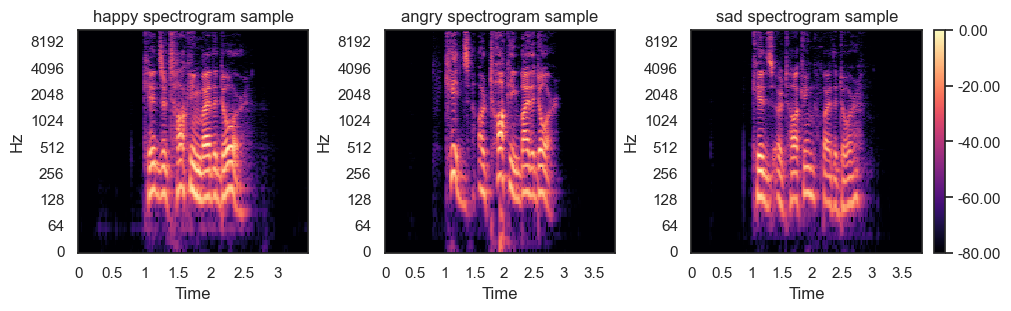

In [10]:
fig, ax = plt.subplots(1,3,figsize = (10,3),constrained_layout=True)
librosa.display.specshow(H_db,x_axis='time', y_axis='log', ax=ax[0])
ax[0].set_title('happy spectrogram sample') 
librosa.display.specshow(A_db,x_axis='time', y_axis='log', ax=ax[1])
ax[1].set_title('angry spectrogram sample') 
librosa.display.specshow(S_db,x_axis='time', y_axis='log', ax=ax[2])
ax[2].set_title('sad spectrogram sample') 
fig.colorbar(librosa.display.specshow(S_db,x_axis='time', y_axis='log', ax=ax[2])
             ,ax=ax[2], format=f'%0.2f')
plt.show()

## Mel spectrogram

The mel scale is a perceptual scale of pitches judged by listeners to be equal in distance from one another. It is based on the idea that the human ear perceives pitch changes logarithmically, rather than linearly. Mel spectrograms are often used in audio processing applications because they better represent the way humans perceive sound. [Source](https://technicqa.com/what-is-the-difference-between-mel-spectrogram-and-spectrogram/)

In [11]:
S = librosa.feature.melspectrogram(y=(librosa.load(happy_files[0]))[0],
                                   sr=(librosa.load(happy_files[0]))[1],
                                   n_mels=128 * 2,)
H_db_mel = librosa.amplitude_to_db(S, ref=np.max)
S = librosa.feature.melspectrogram(y=(librosa.load(angry_files[0]))[0],
                                   sr=(librosa.load(angry_files[0]))[1],
                                   n_mels=128 * 2,)
A_db_mel = librosa.amplitude_to_db(S, ref=np.max)
S = librosa.feature.melspectrogram(y=(librosa.load(sad_files[0]))[0],
                                   sr=(librosa.load(sad_files[0]))[1],
                                   n_mels=128 * 2,)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

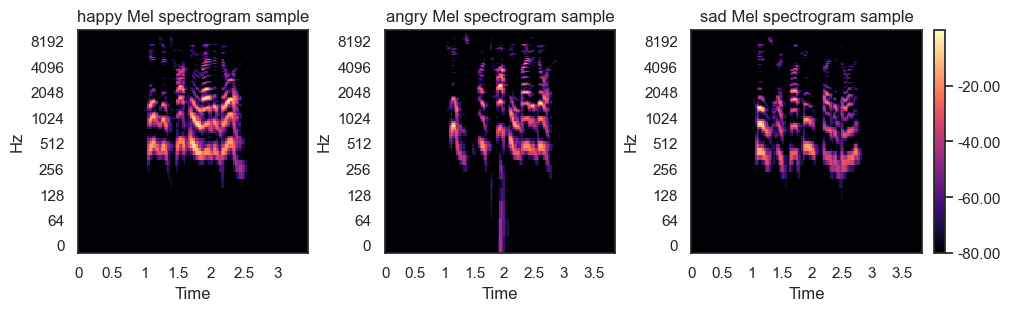

In [12]:
fig, ax = plt.subplots(1,3,figsize = (10,3),constrained_layout=True)
librosa.display.specshow(H_db_mel,x_axis='time', y_axis='log', ax=ax[0])
ax[0].set_title('happy Mel spectrogram sample') 
librosa.display.specshow(A_db_mel,x_axis='time', y_axis='log', ax=ax[1])
ax[1].set_title('angry Mel spectrogram sample') 
librosa.display.specshow(S_db_mel,x_axis='time', y_axis='log', ax=ax[2])
ax[2].set_title('sad Mel spectrogram sample') 
fig.colorbar(librosa.display.specshow(S_db_mel,x_axis='time', y_axis='log', ax=ax[2])
             ,ax=ax[2], format=f'%0.2f')
plt.show()

## Data Extraction and Cleaning

The Goal here is to transform the raw signal into a given frequency, then remove silences, set all of the signals to the same set length by either padding with zero for short signals or cutting, followed by mel spectrogram transformation before feeding it into the model.

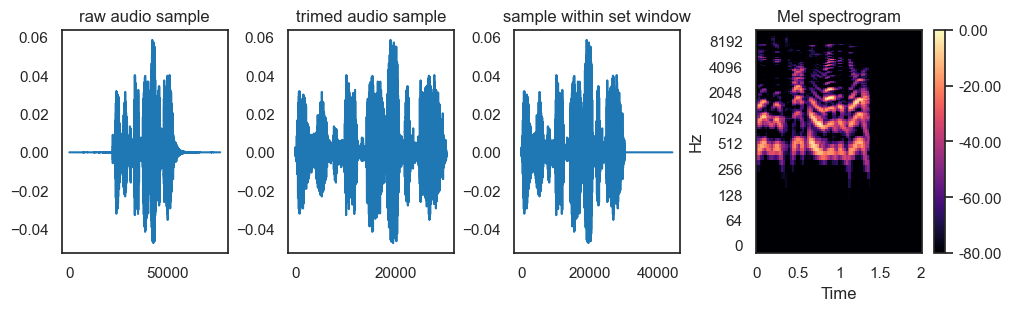

In [13]:
##The demonstration is done on one file then applied to all with a function

# Load the audio file
y, sr = librosa.load(happy_files[0])
# Resample the audio signal to a new sampling rate
new_sr = 22050
y = librosa.resample(y,orig_sr=sr, target_sr=new_sr)

# remove silence
y_trimmed, _ = librosa.effects.trim(y, top_db=10)

#padded or cut to new length
set_time = 2 #unit is seconds
new_len = set_time*new_sr
num_zeros = new_len - len(y_trimmed) #zeros to pad
new_y = (np.pad(y_trimmed, (0, num_zeros), 'constant')) if len(y_trimmed)<new_len else y_trimmed[0: new_len]
    
#mel spectrogram
S = librosa.feature.melspectrogram(y=new_y, sr=new_sr, n_mels=128 * 2,)
H_db_mel = librosa.amplitude_to_db(S, ref=np.max)
db = (H_db_mel+80)/80 # normalization to 1

fig, ax = plt.subplots(1,4,figsize = (10,3),constrained_layout=True)
ax[0].plot(y)
ax[0].set_title('raw audio sample') 
ax[1].plot(y_trimmed)
ax[1].set_title('trimed audio sample') 
ax[2].plot(new_y)
ax[2].set_title('sample within set window') 
librosa.display.specshow(H_db_mel,x_axis='time', y_axis='log', ax=ax[3])
ax[3].set_title('Mel spectrogram') 
fig.colorbar(librosa.display.specshow(H_db_mel,x_axis='time', y_axis='log', ax=ax[3])
             ,ax=ax[3], format=f'%0.2f')
plt.show()

In [14]:
happy_array = audiotoarray('Happy')
happy_array = happy_array.reshape(((len(happy_array)), 256, 87, 1))
print(f'happy array shape {happy_array.shape}')

angry_array = audiotoarray('Angry')
angry_array = angry_array.reshape(((len(angry_array)), 256, 87, 1))
print(f'angry array shape {angry_array.shape}')

sad_array = audiotoarray('Sad')
sad_array = sad_array.reshape(((len(sad_array)), 256, 87, 1))
print(f'sad array shape {sad_array.shape}')

happy array shape (2167, 256, 87, 1)
angry array shape (2167, 256, 87, 1)
sad array shape (2167, 256, 87, 1)


In [15]:
X = np.concatenate((happy_array,angry_array,sad_array))
print(f'X shape: {X.shape}')
y = np.concatenate((np.zeros(len(happy_array)), np.ones(len(angry_array)),np.full(len(sad_array), 2) ))
print(f'y shape: {y.shape}')

X shape: (6501, 256, 87, 1)
y shape: (6501,)


## Prediction with CNN

Here, the Mel spectrogram is fed into the model and in essence is treated as grayscale image

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42,test_size = 0.10)

In [17]:
# Define the CNN model
model = keras.Sequential(
    [
        keras.Input(shape=(256, 87, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu",
                      kernel_regularizer = regularizers.l1_l2(l1 = 0.000, l2 = 0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.3),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", 
                      kernel_regularizer = regularizers.l1_l2(l1 = 0.000, l2 = 0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(3, activation="softmax"),
    ]
)
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer = RMSprop(learning_rate=0.001), metrics=["accuracy"])

In [18]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=15, 
                    validation_split=0.1,verbose=0, callbacks=[TqdmCallback(verbose=1)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

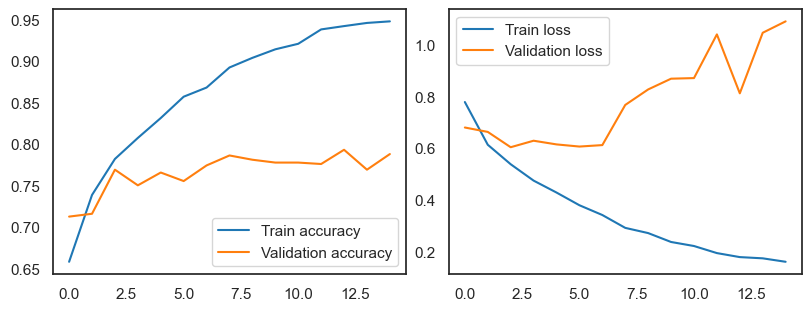

In [19]:
# Visualize the accuracy and loss
fig, ax = plt.subplots(1,2,figsize = (8,3),constrained_layout=True)
ax[0].plot(history.history['accuracy'], label='Train accuracy')
ax[0].plot(history.history['val_accuracy'], label='Validation accuracy')
ax[0].legend();
ax[1].plot(history.history['loss'], label='Train loss')
ax[1].plot(history.history['val_loss'], label='Validation loss')
ax[1].legend();

In [20]:
# let's evaluate the model on the test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'The test accuracy is {round(test_accuracy*100,2)} %')

21/21 [==============================] - 1s 49ms/step - loss: 1.2091 - accuracy: 0.7773
The test accuracy is 77.73 %


# Conclusion

Overall, a good accuracy of 77.7% was achieved for the distinction of happy, sad and angry sounds.A slightly better score could have been obtained with further tuning